In [1]:
import numpy as np
import pandas as pd
import statistics as st
from zipfile import ZipFile
import datetime

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# библиотеки для работы с данными
import category_encoders as ce
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from geopy.distance import distance

# библиотеки для работы с текстовыми данными
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from string import punctuation

# инструмент для разбивки:  
from sklearn.model_selection import train_test_split 

# библиотеки для обучения:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.feature_selection import f_classif # инструменты для оценки значимости признаков  

# фиксируем RANDOM_SEED
RANDOM_SEED = 32

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# читаем данные
with ZipFile('data/sf-booking.zip') as myzip:
    df_train = pd.read_csv(myzip.open('hotels_train.csv'))
    df_test = pd.read_csv(myzip.open('hotels_test.csv'))
    sample_submission = pd.read_csv(myzip.open('submission.csv'))
    
# удаление дубликатов в трейн
df_train.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)    

# выделим 20% данных на валидацию до feature engineering, чтобы исключить утечку данных
X_tr, X_val, _, _ = train_test_split(df_train, df_train['reviewer_score'], test_size=0.2, stratify=df_train['reviewer_score'],
                                            random_state=RANDOM_SEED)
print(f'Делим train {df_train.shape}, на выборку для обучения {X_tr.shape} и для валидации {X_val.shape}')
df_train_tr = pd.DataFrame(X_tr, columns=df_train.columns)
df_train_val = pd.DataFrame(X_val, columns=df_train.columns)
    
# объединяем трейн, валидационную выборку и тест в один датасет
df_train_tr['sample'] = 1
df_train_val['sample'] = 2
df_test['sample'] = 0
df_test['reviewer_score'] = 0
data = pd.concat([df_train_tr, df_train_val, df_test], ignore_index=False)

Делим train (386496, 17), на выборку для обучения (309196, 17) и для валидации (77300, 17)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 184758 to 128934
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  obje

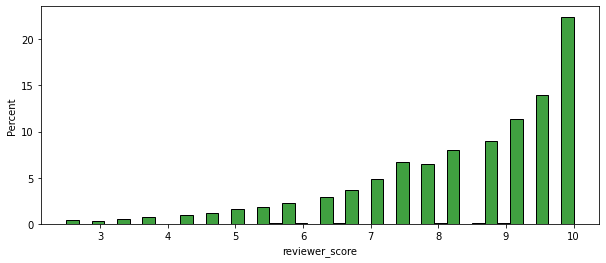

In [4]:
# посмотрим на распределение значений таргета
fig, ax = plt.subplots(ncols=1, figsize=(10, 4))
sns.histplot(df_train['reviewer_score'], ax=ax, bins=40, color='green', stat='percent');

В основном таргет принимает дискретные значения с постоянным шагом. Есть небольшой % значений, не попадающих в этот шаг, связанных с уже не используемой на сайте шкалой. Определим интервалы для перевода этих значений в ближайшие по новой шкале.

In [5]:
# выделяем основные значения таргета и границы присоединяемых к ним интервалов
rc_int = [[round(i * 0.4175 + 2.5, 1), round(i * 0.4175 + 2.29125, 2), round(i * 0.4175 + 2.70875, 2)] for i in range(19)]
rc_list = np.array([i[0] for i in rc_int])
f'Основные значения таргета {list(rc_list)}'

'Основные значения таргета [2.5, 2.9, 3.3, 3.8, 4.2, 4.6, 5.0, 5.4, 5.8, 6.3, 6.7, 7.1, 7.5, 7.9, 8.3, 8.8, 9.2, 9.6, 10.0]'

In [6]:
# заполняем пропущенные координаты
dict_lat = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': 48.219569,
 'City Hotel Deutschmeister': 48.220852,
 'Cordial Theaterhotel Wien': 48.209549,
 'Derag Livinghotel Kaiser Franz Joseph Vienna': 48.245451,
 'Fleming s Selection Hotel Wien City': 48.209402,
 'Holiday Inn Paris Montmartre': 48.888909,
 'Hotel Advance': 41.383231,
 'Hotel Atlanta': 48.22041,
 'Hotel City Central': 48.213587,
 'Hotel Daniel Vienna': 48.188815,
 'Hotel Park Villa': 48.233565,
 'Hotel Pension Baron am Schottentor': 48.2168,
 'Maison Albar Hotel Paris Op ra Diamond': 48.875317,
 'Mercure Paris Gare Montparnasse': 48.839996,
 'NH Collection Barcelona Podium': 41.391548,
 'Renaissance Barcelona Hotel': 41.392685,
 'Roomz Vienna': 48.186811,
 'Best Western Hotel City': 45.479289,
 'Hotel Auriga': 45.484053,
 'Holiday Inn Milan Garibaldi Station': 45.48882, 
 'Hotel VIU Milan': 45.483288,
 'Corus Hotel Hyde Park': 51.511668,
 'Lancaster London': 51.512297,
 }
dict_lng = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': 16.285592,
 'City Hotel Deutschmeister': 16.366612,
 'Cordial Theaterhotel Wien': 16.351463,
 'Derag Livinghotel Kaiser Franz Joseph Vienna': 16.343009,
 'Fleming s Selection Hotel Wien City': 16.353445,
 'Holiday Inn Paris Montmartre': 2.333153,
 'Hotel Advance': 2.162967,
 'Hotel Atlanta': 16.355819,
 'Hotel City Central': 16.379908,
 'Hotel Daniel Vienna': 16.38378,
 'Hotel Park Villa': 16.345665,
 'Hotel Pension Baron am Schottentor': 16.359906,
 'Maison Albar Hotel Paris Op ra Diamond': 2.323392,
 'Mercure Paris Gare Montparnasse': 2.323562,
 'NH Collection Barcelona Podium': 2.177894,
 'Renaissance Barcelona Hotel': 2.167398,
 'Roomz Vienna': 16.420717,
 'Best Western Hotel City': 9.210127,
 'Hotel Auriga': 9.200873,
 'Holiday Inn Milan Garibaldi Station': 9.183134, 
 'Hotel VIU Milan': 9.177569,
 'Corus Hotel Hyde Park': -0.177614,
 'Lancaster London': -0.175197,
 }
data_ll = data.copy()
data_ll['lt'] = data_ll[['hotel_name', 'lat']].apply(lambda x: dict_lat.get(x['hotel_name'], x['lat']), axis=1)
data_ll['lg'] = data_ll[['hotel_name', 'lng']].apply(lambda x: dict_lng.get(x['hotel_name'], x['lng']), axis=1)
data_ll = data_ll.drop(['lat', 'lng'], axis=1)

In [7]:
# выделяем 6 городов, где расположены отели, определяем расстояние от отеля до центра города и логарифмируем
# делим энкодером на 6 колонок по городам
dict_city = {
    'Austria': [48.208, 16.374, 'Austria'],
    'France': [48.857, 2.352, 'France'],
    'Italy': [45.464, 9.190, 'Italy'],
    'Netherlands': [52.372, 4.897, 'Netherlands'],
    'Spain': [41.387, 2.169, 'Spain'],
    'Kingdom': [51.507, -0.127, 'Kingdom']
}
N_CITY = 6
data_p = data_ll.copy()
data_p['clt'] = data_p['hotel_address'].apply(lambda x: dict_city.get(x.split()[-1])[0])
data_p['clg'] = data_p['hotel_address'].apply(lambda x: dict_city.get(x.split()[-1])[1])
data_p['city'] = data_p['hotel_address'].apply(lambda x: dict_city.get(x.split()[-1])[2])
data_p['c_dist'] = data_p[['lt', 'lg', 'clt', 'clg']].apply(lambda x: 
    distance((x['lt'], x['lg']), (x['clt'], x['clg'])).km, axis=1)
data_p['c_dist'] = [round(np.log(x+1), 1) for x in data_p['c_dist']]

# encoder = ce.OneHotEncoder(cols=['city'])
# type_bin = encoder.fit_transform(data_p['city'])
# data_p = pd.concat([data_p, type_bin], axis=1)
    
data_p = data_p.drop(['clg', 'clt', 'city'], axis=1)

In [8]:
# выделяем строки, где национальность ревьюера совпадает со страной визита (внутренний)
data_pp = data_p.copy()
data_pp ['inner_visit'] = data_pp[['hotel_address', 'reviewer_nationality']].apply(lambda x: 
            1 if (len(x['reviewer_nationality'].strip(' '))) and (x['hotel_address'].split()[-1] 
            == x['reviewer_nationality'].strip(' ').split()[-1]) else 0, axis=1)

In [9]:
# выделим бинарные признаки для 11 наиболее часто встречающихся национальностей ревьюера
frequent_nationality = list(data_pp['reviewer_nationality'].value_counts().nlargest(11).index)
data_pp['reviewer_nationality'] = data_pp['reviewer_nationality'].apply(lambda x: 
    x if x in frequent_nationality else 'other')

encoder_nat = ce.OneHotEncoder(cols=['reviewer_nationality'])
type_bin_nat = encoder_nat.fit_transform(data_pp['reviewer_nationality'])
data_pp = pd.concat([data_pp, type_bin_nat], axis=1)

c:\Users\Marina\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [10]:
# выделим слова, соответствующие отсутствию комментария, 
# соответствующие критериям букинга и убираем пунктуацию
data_a = data_pp.copy()
data_a['positive_cl'] = data_a['positive_review'].apply(lambda x: '0' if 'no positive' in x.lower() else x.lower())
data_a['negative_cl'] = data_a['negative_review'].apply(lambda x: '0' if 'no negative' in x.lower() else x.lower())
data_a['positive_cl'] = data_a['positive_cl'].apply(lambda x: '0' if x == ' ' else x.strip(' '))
data_a['negative_cl'] = data_a['negative_cl'].apply(lambda x: '0' if x == ' ' else x.strip(' '))

data_a['staff+'] = data_a['positive_cl'].apply(lambda x: 1 if 'staff' in x else 0)
data_a['staff-'] = data_a['negative_cl'].apply(lambda x: 1 if 'staff' in x else 0)
data_a['location+'] = data_a['positive_cl'].apply(lambda x: 1 if 'location' in x else 0)
data_a['location-'] = data_a['negative_cl'].apply(lambda x: 1 if 'location' in x else 0)
data_a['comf+'] = data_a['positive_cl'].apply(lambda x: 1 if 'comf' in x else 0)
data_a['comf-'] = data_a['negative_cl'].apply(lambda x: 1 if 'comf' in x else 0)
data_a['clean+'] = data_a['positive_cl'].apply(lambda x: 1 if 'clean' in x else 0)
data_a['clean-'] = data_a['negative_cl'].apply(lambda x: 1 if 'clean' in x else 0)
data_a['facilit+'] = data_a['positive_cl'].apply(lambda x: 1 if 'facilit' in x else 0)
data_a['facilit-'] = data_a['negative_cl'].apply(lambda x: 1 if 'facilit' in x else 0)
data_a['money+'] = data_a['positive_cl'].apply(lambda x: 1 if ('money' in x) or ('price' in x) else 0)
data_a['money-'] = data_a['negative_cl'].apply(lambda x: 1 if ('money' in x) or ('price' in x) else 0)
data_a['breakfast+'] = data_a['positive_cl'].apply(lambda x: 1 if 'breakfast' in x else 0)
data_a['breakfast-'] = data_a['negative_cl'].apply(lambda x: 1 if 'breakfast' in x else 0)

five_positive = ['nothing more to be desired', 'nothing more to be done', 'nothing not to like', 'nothing to add 10 10', 
                'room decor very comfortable bedsnothing', 'good breakfast nothing else', 'loved it nothing to complain',
                'excellent breakfast nothing to complain']
data_a['positive_cl'] = data_a['positive_cl'].apply(lambda x: '0' if ('nothing' in x 
                                    and 'everything' not in x and x not in five_positive) and len(x.split()) < 6 else x)
data_a['negative_cl'] = data_a['negative_cl'].apply(lambda x: '0' 
                                    if ('nothing' in x or 'anything' in x) and len(x.split()) < 11 else x)

data_a['positive_cl'] = data_a['positive_cl'].apply(lambda x: ''.join([' ' if i in punctuation else i for i in x]))
data_a['negative_cl'] = data_a['negative_cl'].apply(lambda x: ''.join([' ' if i in punctuation else i for i in x]))

In [11]:
# посмотрим, например, на негативные комментарии со словом 'breakfast'
data_a[data_a['negative_cl'].str.contains('breakfast')][['negative_cl']]

,negative_cl
184758,breakfast could have been better
325144,the shower has a fancy design with integrated ...
376934,the breakfast meals were not kept very warm
112888,bed is not comfortable breakfast bad taste air...
316672,the breakfast poor there is always bad smokes ...
...,...
128913,breakfast could have been a bit better organis...
128917,breakfast was very limited and not particularl...
128928,19 for breakfast when there a numerous cafes b...
128929,this price should include breakfast additional...


In [12]:
# посчитаем количество отрицаний в negative_review
data_b = data_a.copy()
data_b['negative_no'] = data_a['negative_cl'].apply(lambda x: len([f'{j} {"" if i + 1 >= len(x.split()) else x.split()[i + 1]}' 
            for i, j in enumerate(x.split()) if j == 'no' or j == 'not']))

data_b['noth_evr'] = data[['negative_review', 'positive_review']].apply(lambda x: 1 if x['negative_review'].startswith(' Nothing')
                                and x['positive_review'].startswith(' Everything') else 0, axis=1)

# очищаем отзывы от stopwords
stops = [s.replace("'", "") for s in list(stopwords.words('english'))]
data_b['positive_cl'] = data_b['positive_cl'].apply(lambda x: ' '.join('' if s in stops else s for s in x.split()))
data_b['negative_cl'] = data_b['negative_cl'].apply(lambda x: ' '.join('' if s in stops else s for s in x.split()))

# считаем кол-во слов в очищенных комментариях
data_b['positive_word_cl'] = data_b['positive_cl'].apply(lambda x: 0 if x == '0' else len(x.split()))
data_b['negative_word_cl'] = data_b['negative_cl'].apply(lambda x: 0 if x == '0' else len(x.split()))

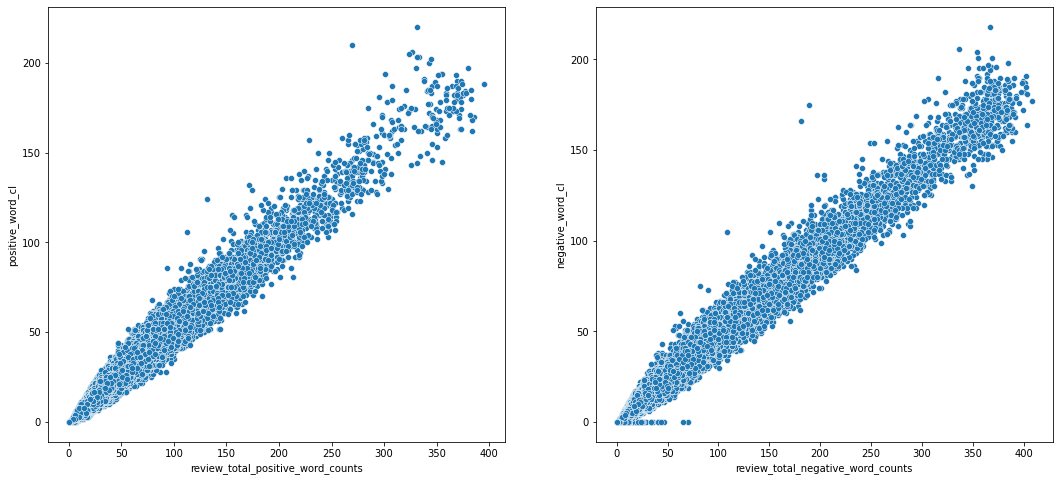

In [13]:
# максимальная длина положительных и отрицательных отзывов сократилась в 2 раза
# так же видно, что выявлены строки с отсутствующим осмысленным негативным комментарием
fig, ax = plt.subplots(ncols=2, figsize=(18, 8))
sns.scatterplot(x=data_b['review_total_positive_word_counts'], y=data_b['positive_word_cl'], marker='o', ax=ax[0])
sns.scatterplot(x=data_b['review_total_negative_word_counts'], y=data_b['negative_word_cl'], marker='o', ax=ax[1]);

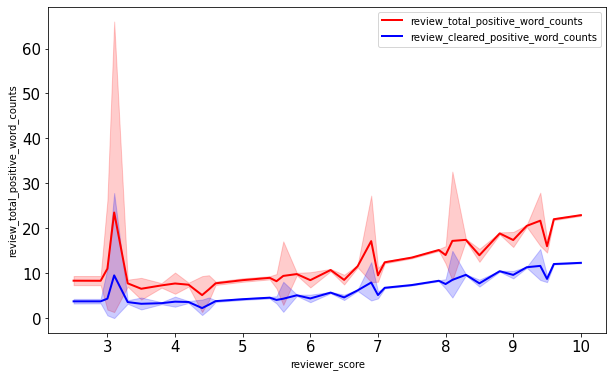

In [35]:
# выбросы в зависимости количества слов в позитивном комментарии от проставленного ревьюером скора стали умереннее
fig = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=data_b[data_b['sample'] != 0],
    x='reviewer_score',
    y='review_total_positive_word_counts', label='review_total_positive_word_counts',
    color='red', linewidth=2
)
sns.lineplot(
    data=data_b[data_b['sample'] != 0],
    x='reviewer_score',
    y='positive_word_cl', label='review_cleared_positive_word_counts',
    color='blue', linewidth=2
)
plt.legend()
plt.show();

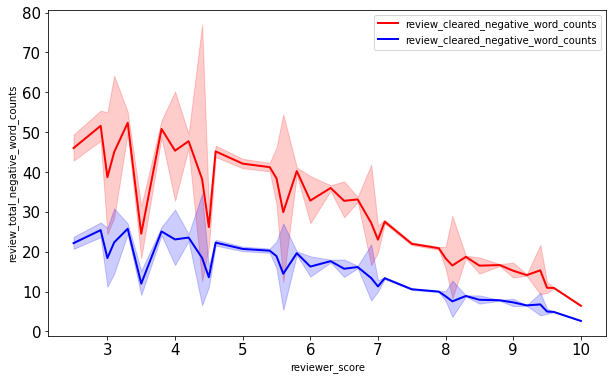

In [36]:
# выбросы в зависимости количества слов в негативном комментарии от проставленного ревьюером скора так же стали умереннее
fig = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=data_b[data_b['sample'] != 0],
    x='reviewer_score',
    y='review_total_negative_word_counts', label='review_cleared_negative_word_counts',
    color='red', linewidth=2
)
sns.lineplot(
    data=data_b[data_b['sample'] != 0],
    x='reviewer_score',
    y='negative_word_cl', label='review_cleared_negative_word_counts',
    color='blue', linewidth=2
)
plt.legend()
plt.show();

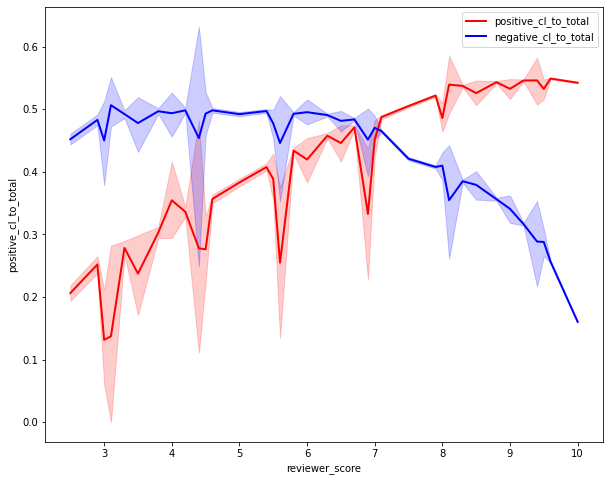

In [19]:
# добавим в признаки отношение количества слов в очищенном комментарии к первоначальному
data_b['positive_cl_to_total'] = (data_b['positive_word_cl'] / data_b['review_total_positive_word_counts']).fillna(0)
data_b['negative_cl_to_total'] = (data_b['negative_word_cl'] / data_b['review_total_negative_word_counts']).fillna(0)
fig = plt.figure(figsize=(10, 8))
sns.lineplot(
    data=data_b[data_b['sample'] != 0],
    x='reviewer_score',
    y='positive_cl_to_total', label='positive_cl_to_total',
    color='red', linewidth=2
)
sns.lineplot(
    data=data_b[data_b['sample'] != 0],
    x='reviewer_score',
    y='negative_cl_to_total', label='negative_cl_to_total',
    color='blue', linewidth=2
);

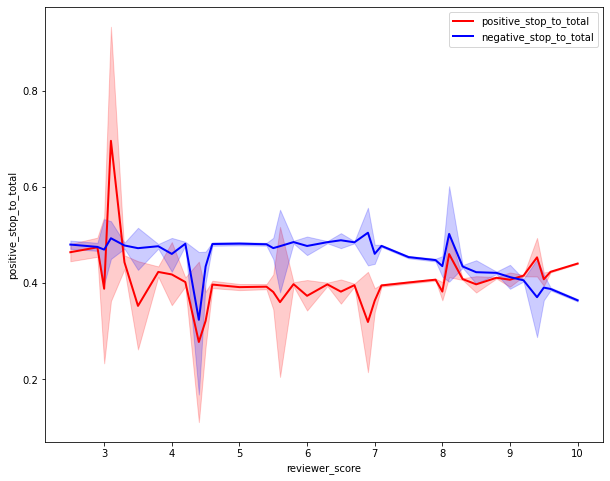

In [22]:
# добавим в признаки отношение количества удаленных стоп-слов в комментарии к первоначальному количеству слов
data_b['positive_stop_to_total'] = ((data_b['review_total_positive_word_counts'] - data_b['positive_word_cl']) / data_b['review_total_positive_word_counts']).fillna(0)
data_b['negative_stop_to_total'] = ((data_b['review_total_negative_word_counts'] - data_b['negative_word_cl']) / data_b['review_total_negative_word_counts']).fillna(0)
fig = plt.figure(figsize=(10, 8))
sns.lineplot(
    data=data_b[data_b['sample'] != 0],
    x='reviewer_score',
    y='positive_stop_to_total', label='positive_stop_to_total',
    color='red', linewidth=2
)
sns.lineplot(
    data=data_b[data_b['sample'] != 0],
    x='reviewer_score',
    y='negative_stop_to_total', label='negative_stop_to_total',
    color='blue', linewidth=2
);

In [23]:
# преобразуем признак tags в категориальные переменные
# посмотрим на строку, содержащую максимальное число тэгов
data_tags = data.loc[:, ['tags']]
data_tags['tags'] = data['tags'].apply(lambda x: x.strip("[").strip("]").strip("' ").strip(" '"))
data_tags['tags'] = data_tags['tags'].apply(lambda x: x.split(" ', ' "))
data_tags.loc[385641, 'tags']

['With a pet',
 'Leisure trip',
 'Couple',
 'Deluxe Room',
 'Stayed 5 nights',
 'Submitted from a mobile device']

In [24]:
# разделим tags по столбцам
data_tags['pet'] = data_tags['tags'].apply(lambda x: x[0] if x[0] == 'With a pet' else 'No info')
data_tags['1+'] = data_tags['tags'].apply(lambda x: x[1:] if x[0] == 'With a pet' else x)
data_tags['trip'] = data_tags['1+'].apply(lambda x: x[0] if 'trip' in x[0] else 'No info')
data_tags['2+'] = data_tags['1+'].apply(lambda x: x[1:] if 'trip' in x[0] else x)
data_tags['group'] = data_tags['2+'].apply(lambda x: x[0])
data_tags['3+'] = data_tags['2+'].apply(lambda x: x[1:] if len(x) > 1 else '')
data_tags['room'] = data_tags['3+'].apply(lambda x: x[0] if x and (x[0] != 'Submitted from a mobile device') else 'No info')
data_tags['4+'] = data_tags['3+'].apply(lambda x: x if x and x[0] == 'Submitted from a mobile device' else '' if len(x) <= 1 else x[1:])
data_tags['night'] = data_tags['4+'].apply(lambda x: int(x[0].strip('Stayed ').strip('s').strip(' night')) if x and ('night' in x[0]) else 0)
data_tags['device'] = data_tags['4+'].apply(lambda x: 'Submitted from a mobile device' if x and x[0] == 'Submitted from a mobile device' else 'No info' if len(x) <= 1 else x[1])

data_tags = data_tags.drop(['1+', '2+', '3+', '4+'], axis=1)

In [25]:
# преобразуем полученные из tags категориальные признаки в числовые и добавим к data_c
data_c = data_b.copy()
pet = {v: i for i, v in enumerate(data_tags['pet'].value_counts().index)}
device = {v: 1 - i for i, v in enumerate(data_tags['device'].value_counts().index)}

data_c['pet'] = data_tags['pet'].apply(lambda x: pet.get(x, -1))
data_c['group'] = data_tags['group']
data_c['room'] = data_tags['room']
data_c['night'] = data_tags['night']
data_c['device'] = data_tags['device'].apply(lambda x: device.get(x, -1))

group = {v: i + 1 for i, v in enumerate(data_c[data_c['sample'] == 1].groupby(
    by=['group'])['reviewer_score'].mean().sort_values(ascending=True).index)}
data_c['group'] = data_c['group'].map(group)

data_c = data_c.drop(['tags'], axis=1)

In [37]:
# посмотрим, например, статистику для групп с разным количеством участников. Чем больше народу, тем веселее.
data_c[data_c['sample'] != 0].groupby(by=['group'])['reviewer_score'].agg('describe').sort_values(by='group', ascending=True)

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
1,81166.0,8.133374,1.720890,2.5,7.1,8.3,9.6,10.0
2,45810.0,8.305324,1.708074,2.5,7.5,8.8,9.6,10.0
3,19787.0,8.440840,1.563503,2.5,7.5,8.8,9.6,10.0
4,49057.0,8.447891,1.625993,2.5,7.5,8.8,9.6,10.0
5,189046.0,8.514234,1.574261,2.5,7.5,9.2,9.6,10.0
6,1630.0,8.511104,1.704446,2.5,7.9,9.2,10.0,10.0


In [27]:
# выделим слова в описании room, для которых медиана таргета выше или ниже, чем средняя по трейну 
data_c['room_s'] = data_tags['room'].apply(lambda x: x.lower().split(' '))

room_dict = {}
for i in data_c[data_c['sample'] == 1]['room_s']:
    for w in i:
        room_dict.update({w: room_dict.get(w, 0) + 1})
        
rw_dict = [[i, w] for w, i in room_dict.items() if w != 'eiffel']
rw_dict.sort(key=lambda x: -x[0])
room_list = [x[1] for x in rw_dict[:80]]

room_columns = []
for w in room_list:
    r_try = data_c[(data_c['sample'] == 1)][['room_s', 'reviewer_score']].apply(
        lambda x: x['reviewer_score'] if w in x['room_s'] else 0, axis=1)
    if (r_try[r_try > 0].median() > 9.2) or (r_try[r_try > 0].describe()['75%'] > 9.6) or (r_try[r_try > 0].median() < 8):
        data_c[f'room_{w}'] = data_c['room_s'].apply(lambda x: 1 if w in x else 0)
        room_columns.append(f'room_{w}')
    
# for col in room_columns:
#     print(col)
#     print(data_c[(data_c['sample'] == 1)&(data_c[col] == 1)]['reviewer_score'].describe())        

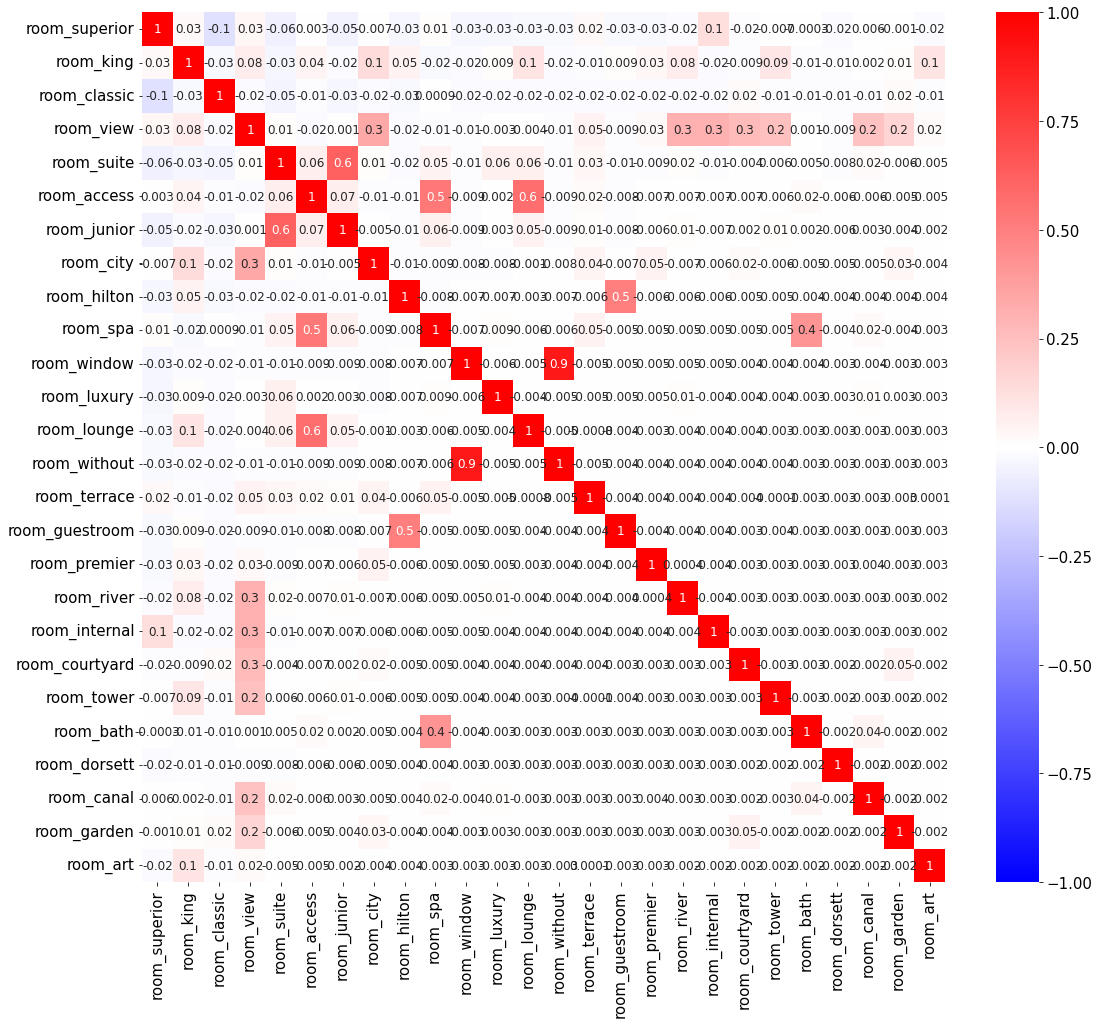

In [30]:
# посмотрим на корреляцию полученных признаков - практически каждый из выделенных признаков с индивидуальным поведением
plt.rcParams['figure.figsize'] = (18, 16)
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
sns.heatmap(data_c[data_c['sample'] != 0][room_columns].corr(), annot=True, annot_kws={"fontsize":12}, fmt='.1g',
            vmin=-1, vmax=1, center= 0, cmap= 'bwr');

In [31]:
# выделим районы по индексам и присвоим категорию по 50% оценки с приведением к основным частотам таргета
data_d = data_c.copy()
data_d['ind'] = data_d['hotel_address'].apply(lambda x: x.split()[-3] if (x.split()[-1] != 'Kingdom') 
                                                   and (x.split()[-1] != 'Netherlands') else x.split()[-4]) 
district = data_d[data_d['sample'] == 1].groupby(by=['ind'])['reviewer_score'].quantile(0.5)
distr_simple  = {6.9: 7.1, 7.7: 7.5, 7.95: 7.9, 8: 7.9, 8.15: 8.3, 8.55: 8.3, 9: 8.8, 9.35: 9.2, 9.55: 9.6}
district = district.apply(lambda x: distr_simple.get(x, x))
data_d['district'] = data_d['ind'].map(district)
data_d = data_d.drop(['ind'], axis=1)

In [32]:
# видим, что категория district отражает динамику роста average_score
data_d.groupby(by=['district'])['average_score'].describe()

,count,mean,std,min,25%,50%,75%,max
district,,,,,,,,
5.8,10.0,7.500000,0.000000,7.5,7.5,7.5,7.5,7.5
7.1,4197.0,6.966690,0.517179,6.4,6.8,6.8,7.0,8.4
7.5,5545.0,7.452011,0.373915,5.2,7.3,7.4,7.6,8.4
7.9,38362.0,7.838442,0.459050,6.6,7.6,7.8,8.1,8.9
8.3,104857.0,8.083498,0.509052,6.8,7.8,8.1,8.4,9.5
8.8,135054.0,8.359358,0.418016,6.4,8.1,8.4,8.6,9.5
9.2,197978.0,8.667030,0.387818,6.6,8.4,8.7,8.9,9.8
9.6,29428.0,8.991688,0.341011,8.2,8.8,9.1,9.2,9.6


In [33]:
# получим неделю года из review_date
data_w = data_d.copy()
data_w['week_o_year'] = pd.to_datetime(data_w['review_date'], errors='coerce').dt.isocalendar().week
week_o_year = {v: i + 1 for i, v in enumerate(data_w[data_w['sample'] == 1].groupby(
    by=['week_o_year'])['reviewer_score'].mean().sort_values(ascending=True).index)}
data_w['week_o_year'] = data_w['week_o_year'].map(week_o_year)

# выделяем день недели
data_w['day_of_week'] = pd.to_datetime(data_w['review_date'], errors='coerce').dt.dayofweek
# data_w['r_weekend'] = data_w['r_week'].apply(lambda x: 0 if x in range(0, 5) else 1)

# получим год и месяц из review_date
# bin_w_encoder = ce.BinaryEncoder(cols=['week_o_year'])
# week_bin = bin_w_encoder.fit_transform(data_m['week_o_year'])
# data_m = pd.concat([data_m, week_bin], axis=1)
# data_m = data_m.drop(['week_o_year'], axis=1)

# data_m['r_month'] = pd.to_datetime(data_m['review_date'], errors='coerce').dt.month
# # data_m['r_year'] = pd.to_datetime(data_m['review_date'], errors='coerce').dt.year корреляция -0,9 с since_review

# # сделаем из месяца бинарный признак
# data_m['r_quart'] = data_m['r_month'].apply(lambda x: x // 3 if x != 12 else 0)
# data_m['r_month'] = data_m['r_month'].apply(lambda x: x % 3)
# bin_encoder = ce.BinaryEncoder(cols=['r_month'])
# month_bin = bin_encoder.fit_transform(data_m['r_month'])
# data_m = pd.concat([data_m, month_bin], axis=1)
# data_m = data_m.drop(['r_month'], axis=1)

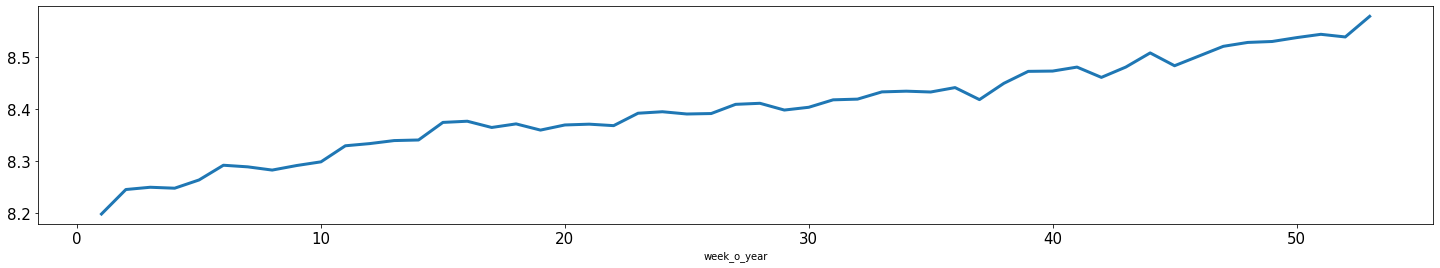

In [38]:
# посмотрим, отличается ли в среднем рейтинг для разных недель года
data_w[data_w['sample'] != 0].groupby(by=['week_o_year'])['reviewer_score'].mean().plot(kind='line', figsize=(25, 4), lw=3);

In [39]:
# выделим числовое значение из days_since_review
data_m = data_w.copy()
# data_m['since_review'] = data_m['days_since_review'].apply(lambda x: int(x.split()[0]))

# выделяем процент непроверенных скоров и общее количество проверенных скоров
data_m['perc_without_check'] = round(data_m['additional_number_of_scoring'] / data_m['total_number_of_reviews'], 3)
data_m['checked_reviews'] = data_m['total_number_of_reviews'] - data_m['additional_number_of_scoring']
# data_m['perc_without_check'] = round(data_m['additional_number_of_scoring'] / data_m['checked_reviews'], 3) 
# data_m['ln_checked_reviews'] = [x**0.3 for x in data_m['checked_reviews']]

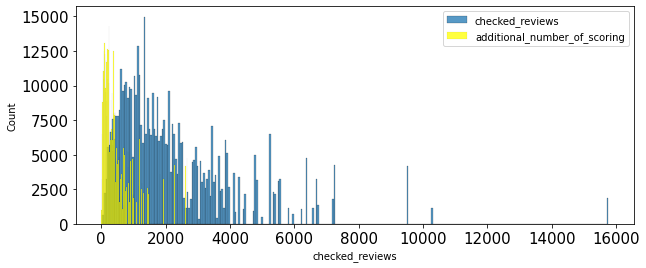

In [42]:
# распределения частот checked_reviews и additional_number_of_scoring отличаются
fig = plt.subplots(figsize=(10, 4))
sns.histplot(data_m['checked_reviews'], label='checked_reviews')
sns.histplot(data_m['additional_number_of_scoring'], color='yellow', label='additional_number_of_scoring')
plt.legend()
plt.show();

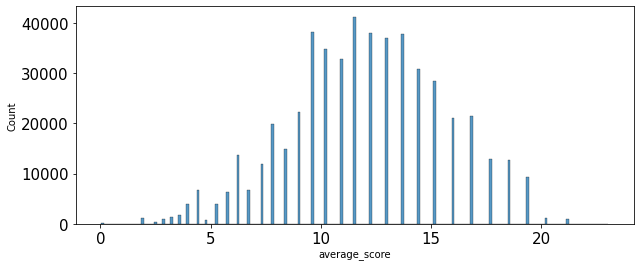

In [43]:
# применим нелинейное преобразование, чтобы привести распределение частот average_score к симметричному виду
data_nr = data_m.copy()
data_nr['average_score'] = data_nr['average_score'].apply(lambda x: (x - 5)**2)

fig = plt.subplots(figsize=(10, 4))
sns.histplot(data_nr['average_score']);

In [44]:
# явные выбросы - нет или положительный комментарий, а оценки минимальные - удалим потом эти строки
data[(data_nr['noth_evr'] == 1)&((data_nr['reviewer_score'] >= 2.5)&(data_nr['reviewer_score'] <= 5))]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
99554,IJdock 6 Amsterdam City Center 1013 MM Amsterd...,550,11/8/2015,8.8,Room Mate Aitana,India,Nothing,2,4097,Everything,2,3,2.5,"[' Business trip ', ' Solo traveler ', ' Queen...",634 day,52.384606,4.894187,1
236444,Aldwych Westminster Borough London WC2B 4DD Un...,409,11/15/2015,8.4,The Waldorf Hilton,United Kingdom,Nothing,2,1479,Everything,2,20,2.9,"[' Leisure trip ', ' Couple ', ' Queen Hilton ...",627 day,51.513198,-0.117450,1
209463,Mallorca 1 23 Sants Montju c 08014 Barcelona S...,390,4/7/2016,7.6,Expo Hotel Barcelona,Pakistan,Nothing,2,4646,Everything is perfect in this hotel as I have...,18,1,5.0,"[' Business trip ', ' Solo traveler ', ' Small...",483 day,41.379205,2.142799,1


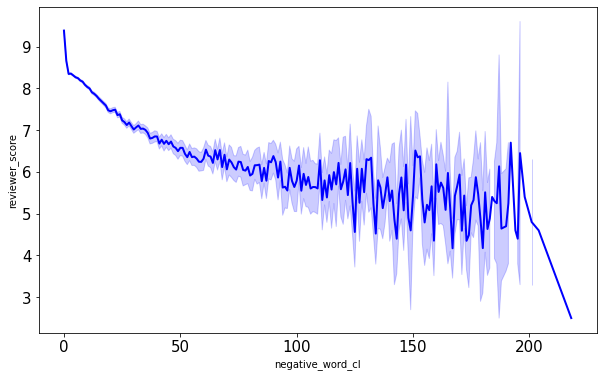

In [45]:
# развернем график количества слов в негативном комментарии
# видно, что при количестве слов больше 100 информативность признака теряется
fig = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=data_b[(data_b['sample'] != 0)],
    x='negative_word_cl',
    y='reviewer_score',
    color='blue', linewidth=2
);

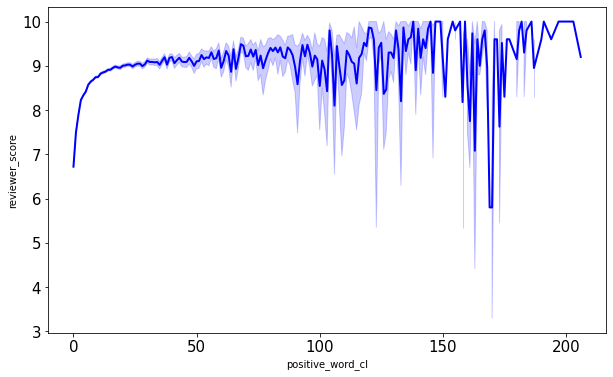

In [46]:
# аналогично развернем график количества слов в позитивном комментарии
# информативность признака начинает теряться при количестве слов больше 60
fig = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=data_b[data_b['sample'] == 1],
    x='positive_word_cl',
    y='reviewer_score',
    color='blue', linewidth=2
);

In [62]:
# посмотрим, какие дополнительные признаки можно построить
data_t = data_nr.copy()

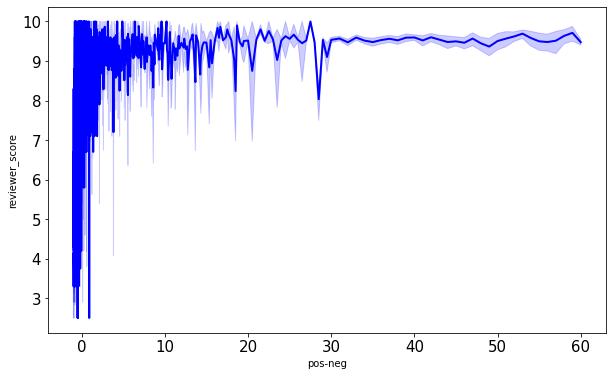

In [63]:
# например, разницу в количестве слов в положительном и отрицательном комментарии после очистки 
# разделить на количество слов в отрицательном комментарии 
# (плюс 1, чтобы не было нулей в знаменателе)
data_t['positive_word_cl'] = data_t['positive_word_cl'].apply(lambda x: 60 if x > 60 else x)
data_t['negative_word_cl'] = data_t['negative_word_cl'].apply(lambda x: 100 if x > 100 else x)
fig = plt.subplots(figsize=(10, 6))
data_t['pos-neg'] = ((data_t['positive_word_cl'] - data_t['negative_word_cl']) / (data_t['negative_word_cl'] + 1))
sns.lineplot(
    data=data_t[data_t['sample'] != 0],
    x='pos-neg',
    y='reviewer_score',
    color='blue', linewidth=2
);

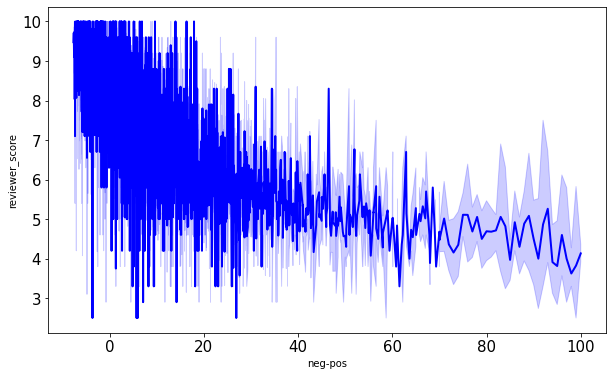

In [64]:
# и разницу в количестве слов в положительном и отрицательном комментарии после очистки 
# разделить на корень из количества слов в положительном комментарии 
# (так же плюс 1, чтобы не было нулей в знаменателе)
fig = plt.subplots(figsize=(10, 6))
data_t['neg-pos'] = - ((data_t['positive_word_cl'] - data_t['negative_word_cl']) / (data_t['positive_word_cl'] + 1)**0.5)
sns.lineplot(
    data=data_t[data_t['sample'] != 0],
    x='neg-pos',
    y='reviewer_score',
    color='blue', linewidth=2
);

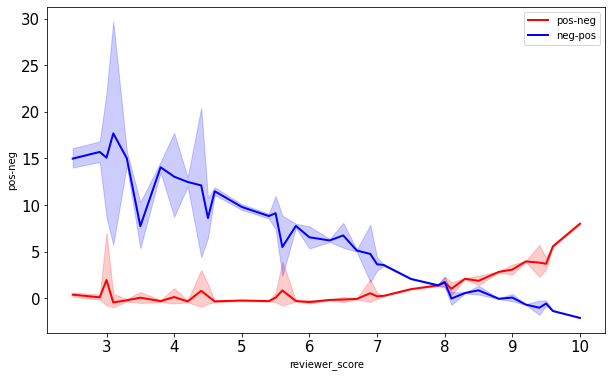

In [65]:
# развернем эти показатели вдоль оси y
fig = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=data_t[data_t['sample'] != 0],
    x='reviewer_score',
    y='pos-neg', label='pos-neg',
    color='red', linewidth=2
)
sns.lineplot(
    data=data_t[data_t['sample'] != 0],
    x='reviewer_score',
    y='neg-pos', label='neg-pos',
    color='blue', linewidth=2
);

In [59]:
# смотрим на статистики последних добавленных признаков
data_t.iloc[:, -10:].describe()

,room_canal,room_garden,room_art,district,week_o_year,day_of_week,perc_without_check,checked_reviews,pos-neg,neg-pos
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000
mean,0.002047,0.001977,0.001636,8.802728,26.471101,2.721598,0.179097,2245.984006,3.334752,1.045292
std,0.045196,0.044419,0.040409,0.501021,15.222795,2.084382,0.075777,1925.766642,6.573883,6.261232
min,0.000000,0.000000,0.000000,5.800000,1.000000,0.000000,0.020000,33.000000,-0.980392,-5.388159
25%,0.000000,0.000000,0.000000,8.300000,13.000000,1.000000,0.109000,943.000000,-0.500000,-2.333333
50%,0.000000,0.000000,0.000000,8.800000,26.000000,2.000000,0.176000,1723.000000,0.333333,-0.707107
75%,0.000000,0.000000,0.000000,9.200000,40.000000,5.000000,0.239000,3010.000000,4.000000,2.236068
max,1.000000,1.000000,1.000000,9.600000,53.000000,6.000000,0.397000,15766.000000,30.000000,50.000000


In [60]:
# убеждаемся, что в ходе преобразований не получили пропуски
data_t.isna().sum()[data_t.isna().sum().values > 0]

Series([], dtype: int64)

### Обучение модели

In [66]:
# удаляем выбросы с низким скором
df = data_t.copy()
mask = (df['noth_evr'] == 1)&((df['reviewer_score'] >= 2.5)&(df['reviewer_score'] <= 5))
df = df[~mask]

# удаляем нечисловые и лишние столбцы
# при работе с RandomForestRegressor нет необходимости исключать высококоррелированные признаки 
# - это не ухудшит качество модели, т.к. данная модель не связана с тензорами и не считает обратную матрицу
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df = df.drop(object_columns, axis=1)
df = df.drop(['review_total_positive_word_counts', 'review_total_negative_word_counts'], axis=1)

# переформатируем данные для обучения
X_train = df.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)
y_train = df.query('sample == 1').reviewer_score.values
X_valid = df.query('sample == 2').drop(['sample', 'reviewer_score'], axis=1)
y_valid = df.query('sample == 2').reviewer_score.values

# таргет части трейна для обучения приводим к основным частотам
y_train = np.array([[i[0] for i in rc_int if i[1] < y <= i[2]][0] for y in y_train])   

for RANDOM_SEED in (32, ):
    # обучаем модель на выделенной части train
    model_part = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
    model_part.fit(X_train, y_train)
    # используем обученную модель для предсказания рейтинга в валидационной части train
    y_train_pred = model_part.predict(X_train)
    y_pred = model_part.predict(X_valid)
    # print('RANDOM_SEED:', RANDOM_SEED)
    print('MAPE train:', metrics.mean_absolute_percentage_error(y_train, y_train_pred))
    print('MAPE valid:', metrics.mean_absolute_percentage_error(y_valid, y_pred))   
    
    # полученное предсказание приводим к основным частотам и оцениваем результат
    y_pred_norm = rc_list[abs(y_pred[None, :] - rc_list[:, None]).argmin(axis=0)]
    print('MAPE adjusted:', metrics.mean_absolute_percentage_error(y_valid, y_pred_norm))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s


MAPE train: 0.04676346548676829
MAPE valid: 0.12647955867775765
MAPE adjusted: 0.12579952872787287


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.8s finished


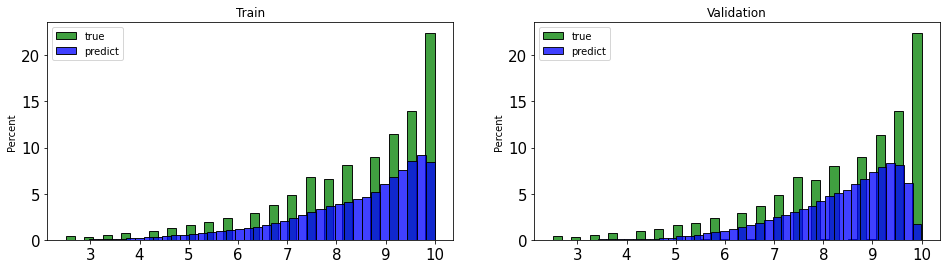

In [75]:
# посмотрим на распределение предсказанных оценок тестовой и валидационной выборок по сравнению с таргетом
fig, ax = plt.subplots(ncols=2, figsize=(16, 4))
y_train_pred_norm = rc_list[abs(y_train_pred[None, :] - rc_list[:, None]).argmin(axis=0)]
sns.histplot(y_train, ax=ax[0], bins=40, color='green', stat='percent', label='true')
sns.histplot(y_train_pred, ax=ax[0], bins=40, color='blue', stat='percent', label='predict')
ax[0].set_title('Train')
ax[0].legend()

sns.histplot(y_valid, ax=ax[1], bins=40, color='green', stat='percent', label='true')
sns.histplot(y_pred, ax=ax[1], bins=40, color='blue', stat='percent', label='predict')
ax[1].set_title('Validation')
ax[1].legend()
plt.show();

В общем - модель уловила зависимость, но имеет склонность предсказывать значения ближе к медианным и плохо предсказывает оценки, близкие к нижней и верхней границе.

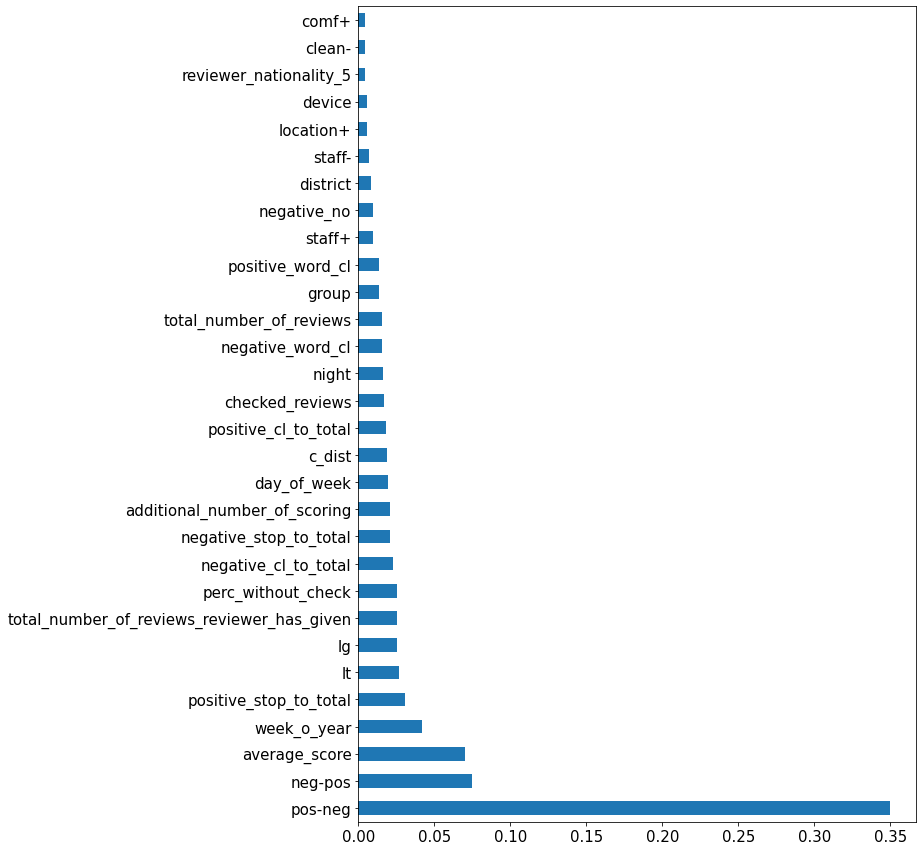

In [67]:
# важность признаков для модели
plt.rcParams['figure.figsize'] = (10,15)
feat_importances = pd.Series(model_part.feature_importances_, index=X_train.columns)
feat_importances.nlargest(30).plot(kind='barh');

In [70]:
# посмотрим как зависит качество модели от количества признаков, на которых модель обучается

# удаляем нечисловые и лишние столбцы
# object_columns = [s for s in df.columns if df[s].dtypes == 'object']
# df = df.drop(object_columns, axis=1)
# df = df.drop(['review_total_positive_word_counts', 'review_total_negative_word_counts'], axis=1)

mape_train, mape_valid = [], []
y_train = df.query('sample == 1').reviewer_score.values
y_valid = df.query('sample == 2').reviewer_score.values
# таргет части трейна для обучения приводим к основным частотам
y_train = np.array([[i[0] for i in rc_int if i[1] < y <= i[2]][0] for y in y_train]) 
for fi in [i for i in range(2, 8)] + [7 + i*10 for i in range(1, 8)]:
    # ограничиваем количество признаков
    dfi = df[list(feat_importances.nlargest(fi).index) + ['sample']]
    X_train = dfi.query('sample == 1').drop(['sample'], axis=1)
    X_valid = dfi.query('sample == 2').drop(['sample'], axis=1)

    # обучаем модель на выделенной части train
    model_fi = RandomForestRegressor(n_estimators=100, verbose=0, n_jobs=-1, random_state=RANDOM_SEED)
    model_fi.fit(X_train, y_train)
    # используем обученную модель для предсказания рейтинга в валидационной части train
    y_train_pred = model_fi.predict(X_train)
    y_pred = model_fi.predict(X_valid)
    mape_train.append(metrics.mean_absolute_percentage_error(y_train, y_train_pred))
    mape_valid.append(metrics.mean_absolute_percentage_error(y_valid, y_pred))
    print(fi, 'features')
    print('   MAPE train:', mape_train[-1])
    print('   MAPE valid:', mape_valid[-1])   

2 features
   MAPE train: 0.13817996926112175
   MAPE valid: 0.14068991554020266
3 features
   MAPE train: 0.1197406912215486
   MAPE valid: 0.13642106592646647
4 features
   MAPE train: 0.07807239133036453
   MAPE valid: 0.1428983026860784
5 features
   MAPE train: 0.06123374253908502
   MAPE valid: 0.1395453673977367
6 features
   MAPE train: 0.05040275160397741
   MAPE valid: 0.13509321638236485
7 features
   MAPE train: 0.05023590136203182
   MAPE valid: 0.134628980655706
17 features
   MAPE train: 0.04858786995988377
   MAPE valid: 0.13153396416352992
27 features
   MAPE train: 0.04742374725523073
   MAPE valid: 0.1283203629017605
37 features
   MAPE train: 0.04692089404226709
   MAPE valid: 0.12686927460932154
47 features
   MAPE train: 0.04678210564747141
   MAPE valid: 0.12662311574556848
57 features
   MAPE train: 0.046774609406109766
   MAPE valid: 0.12650805934515952
67 features
   MAPE train: 0.04676199454227359
   MAPE valid: 0.12645605631458282
77 features
   MAPE train: 

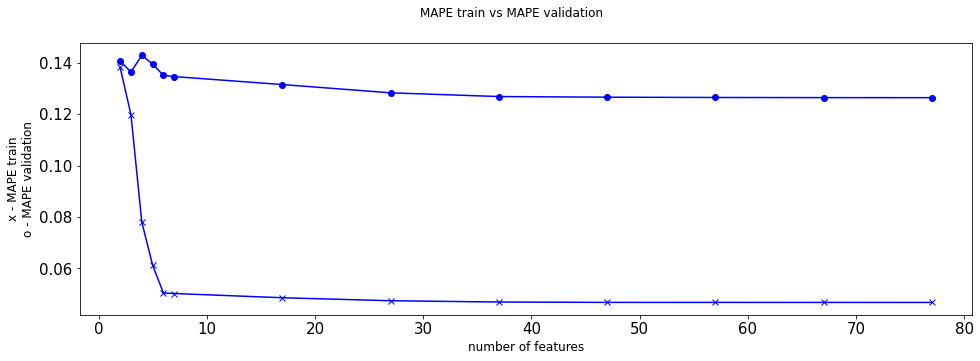

In [71]:
# визуализируем метрики для тестовой и валидационной выборок
fig = plt.subplots(figsize=(16, 5))
plt.plot([i for i in range(2, 8)] + [7 + i*10 for i in range(1, 8)], mape_train, 'xb-')
plt.plot([i for i in range(2, 8)] + [7 + i*10 for i in range(1, 8)], mape_valid, 'ob-')
plt.suptitle('MAPE train vs MAPE validation')
plt.xlabel('number of features', fontsize=12)
plt.ylabel("x - MAPE train\no - MAPE validation", fontsize=12)
plt.show();

Видно, что при добавлении 3-го и 4-го признаков модель переобучается (метрика трейна становится резко лучше, а метрика на валидационной выборке даже ухудшается).

Наверное, это особенность модели, которая может показать очень высокую адаптивность под данные при обучении. Что интересно, если третьим признаком добавить количество дней с момента публикации отзыва (полученные из соответствующего текстового признака) - поле с низкой смысловой нагрузкой и с 700+ уникальных признаков, то уже на трех признаках модель на трейне получит MAPE 0.0467, т.е сразу же покажет идеальное переобучение.

Добавление же всех остальных признаков переобучение не увеличивает, а на сотые доли процента улучшает обе метрики. Т.е данные признаки несут некоторую информацию, полезную модели.

Т.к время обучения модели относительно невелико, нет необходимости в уменьшении количества признаков, пусть будут.

In [76]:
# обучаем модель на всем train
X_train = df.query('sample != 0').drop(['sample', 'reviewer_score'], axis=1)
y_train = df.query('sample != 0').reviewer_score.values
X_test = df.query('sample == 0').drop(['sample', 'reviewer_score'], axis=1)

# весь таргет трейна приводим к основным частотам
y_train = np.array([[i[0] for i in rc_int if i[1] < y <= i[2]][0] for y in y_train])

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
model.fit(X_train, y_train)
predict_submission = model.predict(X_test)

# полученное предсказание приводим к основным частотам и оцениваем результат
predict_submission = rc_list[abs(predict_submission[None, :] - rc_list[:, None]).argmin(axis=0)]
save_time = datetime.datetime.utcnow().strftime('%y.%m.%d_%H.%M')
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv(f'data/submission_{save_time}.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.5s finished


,reviewer_score,id
0,8.8,488440
1,7.9,274649
2,8.3,374688
3,9.6,404352
4,9.6,451596
5,8.3,302161
6,7.9,317079
7,8.3,13963
8,8.3,159785
9,7.5,195089


#### MAPE на тестовой выборке   12.58923

##### Из непроверенного:

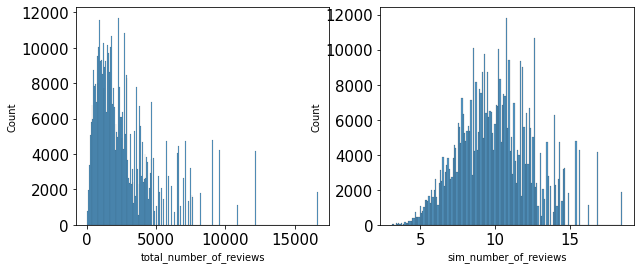

In [78]:
# распределение признака total_number_of_reviews сильно смещено влево, 
# его тоже можно привести к симметричному виду
data['sim_number_of_reviews'] = data['total_number_of_reviews']**0.3
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.histplot(data['total_number_of_reviews'], ax=ax[0])
sns.histplot(data['sim_number_of_reviews'], ax=ax[1]);

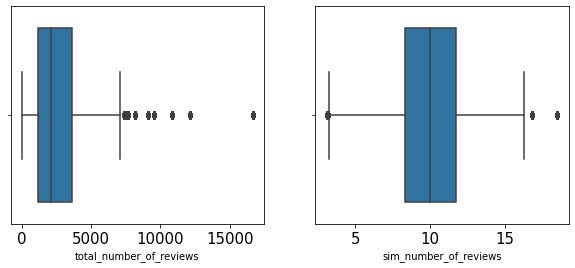

In [79]:
# на боксплотах
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.boxplot(x=data['total_number_of_reviews'], ax=ax[0])
sns.boxplot(x=data['sim_number_of_reviews'], ax=ax[1]);

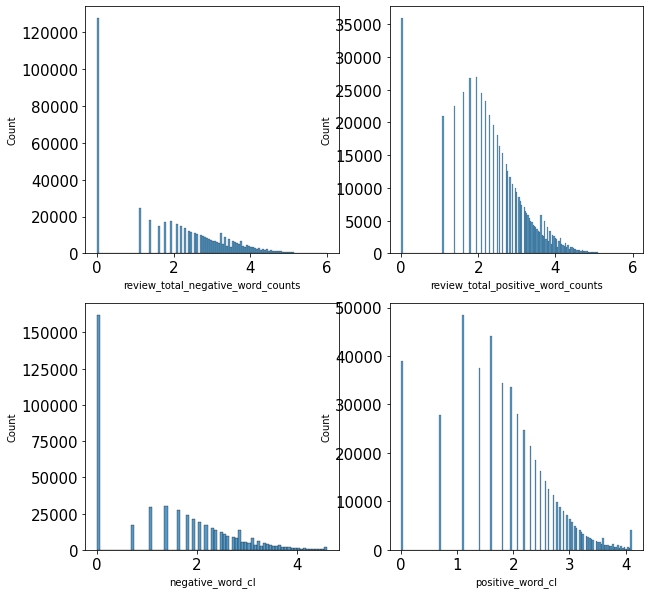

In [87]:
# интересно так же выглядят распределения логарифмов количества слов позитивных и негативных отзывов 
# для исходных и очищенных данных
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
sns.histplot(data['review_total_negative_word_counts'].apply(lambda x: np.log(x+1)), ax=ax[0][0])
sns.histplot(data['review_total_positive_word_counts'].apply(lambda x: np.log(x+1)), ax=ax[0][1])
sns.histplot(df['negative_word_cl'].apply(lambda x: np.log(x+1)), ax=ax[1][0])
sns.histplot(df['positive_word_cl'].apply(lambda x: np.log(x+1)), ax=ax[1][1]);